In [25]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image
from torchvision import transforms

%matplotlib inline

In [26]:
# transformations from IEEE xplore
# transformations code from gemini -
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class FlowerDataset(Dataset):
    def __init__(self, image_tensors, labels, transform=None):
        self.image_tensors = image_tensors
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.image_tensors[idx]
        label = self.labels[idx]


        if not isinstance(image, torch.Tensor):
            # If not a tensor, assume it's a PIL Image and convert
            image = transforms.ToTensor()(image)
        else:
            # If it's already a tensor, ensure it's float
            image = image.float()



        if self.transform:
          image = self.transform(image)


        return image, label

In [27]:
import re
import glob
import os
from PIL import Image
from torchvision import transforms
import torch

def numerical_sort_key(file_path):
    match = re.search(r'\d+', os.path.basename(file_path))
    if match:
        return int(match.group(0))
    return float('inf')

def folder_to_tensor(folder_path):
## SORTS THE FOLDER ACCRODING TO THEIR NUMERICAL ORDER INSTEAD OF LIKE STRINGS


    image_paths = glob.glob(os.path.join(folder_path, '*.png'))

    if not image_paths:
        print(f"No PNG images found in '{folder_path}'.")
        return torch.empty(0)


    image_paths.sort(key=numerical_sort_key)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    images = [transform(Image.open(img_path).convert('RGB')) for img_path in image_paths]

    images_tensor = torch.stack(images)
    print("Tensor shape after stacking:", images_tensor.shape)

    return images_tensor

In [28]:
# CONVERTING ALL OUR FOLDERS TO PYTORCH TENSORS USING OUR FUNCTION
tulips_train_clean = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\clean\tulips')
daisy_train_clean = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\clean\daisy_clean_test\daisy')
dandelion_train_clean = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\clean\dandelion')
roses_train_clean = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\clean\roses')
sunflowers_train_clean = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\clean\sunflowers')

tulips_train_noisy = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\noisy\tulips')
daisy_train_noisy = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\noisy\daisy')
dandelion_train_noisy = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\noisy\dandelion')
roses_train_noisy = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\noisy\roses')
sunflowers_train_noisy = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\train\noisy\sunflowers')

test_noisy = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\test\noisy')

Tensor shape after stacking: torch.Size([391, 3, 128, 128])
Tensor shape after stacking: torch.Size([310, 3, 128, 128])
Tensor shape after stacking: torch.Size([439, 3, 128, 128])
Tensor shape after stacking: torch.Size([313, 3, 128, 128])
Tensor shape after stacking: torch.Size([342, 3, 128, 128])
Tensor shape after stacking: torch.Size([391, 3, 128, 128])
Tensor shape after stacking: torch.Size([310, 3, 128, 128])
Tensor shape after stacking: torch.Size([439, 3, 128, 128])
Tensor shape after stacking: torch.Size([313, 3, 128, 128])
Tensor shape after stacking: torch.Size([342, 3, 128, 128])
Tensor shape after stacking: torch.Size([772, 3, 128, 128])


In [29]:
# DEINING OUR UNET AUTOENCODER
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.conv_down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_down3 = DoubleConv(128,256)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride=2)

        self.conv_down4 = DoubleConv(256,512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.bottleneck = DoubleConv(512, 1024)


        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2,)
        self.conv_up1 = DoubleConv(1024, 512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv_up2 = DoubleConv(512, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv_up3 = DoubleConv(256, 128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv_up4 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size =1)

    def forward(self, x):

        conv1 = self.conv_down1(x)
        pool1 = self.pool1(conv1)

        conv2 = self.conv_down2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv_down3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.conv_down4(pool3)
        pool4 = self.pool4(conv4)


        bottleneck = self.bottleneck(pool4)

        up1 = self.upconv1(bottleneck)
        up1 = torch.cat([up1, conv4], dim=1)
        conv_up1 = self.conv_up1(up1)

        up2 = self.upconv2(conv_up1)
        up2 = torch.cat([up2, conv3], dim=1)
        conv_up2 = self.conv_up2(up2)

        up3 = self.upconv3(conv_up2)
        up3 = torch.cat([up3, conv2], dim=1)
        conv_up3 = self.conv_up3(up3)

        up4 = self.upconv4(conv_up3)
        up4 = torch.cat([up4, conv1], dim=1)
        conv_up4 = self.conv_up4(up4)


        output = self.final_conv(conv_up4)

        return torch.sigmoid(output)





## Training setup

In [30]:
#MAKING A LIST OF ALL CLEAN TRAINING TENSORS TO CONCTENATE LATER
clean_tensors_list = [
    tulips_train_clean,
    daisy_train_clean,
    dandelion_train_clean,
    roses_train_clean,
    sunflowers_train_clean
]
#MAKING A LIST OF ALL NOISY TRAINING TENSORS TO CONCTENATE LATER
noisy_tensors_list = [
    tulips_train_noisy,
    daisy_train_noisy,
    dandelion_train_noisy,
    roses_train_noisy,
    sunflowers_train_noisy
]

clean_images =torch.cat(clean_tensors_list, dim = 0)#CONCATENATING
noisy_images = torch.cat(noisy_tensors_list, dim = 0)#CONCATENATING

full_denoising_dataset = TensorDataset(clean_images, noisy_images) #MAKING THE TRAINING DATASET

train_size_denoising = int(0.8 * len(full_denoising_dataset)) #SPLITTING THE DATASET
val_size_denoising = len(full_denoising_dataset) - train_size_denoising
train_subset_denoising, val_subset_denoising = random_split(full_denoising_dataset, [train_size_denoising, val_size_denoising])

batch_size = 32
train_denoising_dataloader = DataLoader(train_subset_denoising, batch_size=batch_size, shuffle=True)#MAKING THE TRAIN DATALOADER
val_denoising_dataloader = DataLoader(val_subset_denoising, batch_size=batch_size, shuffle=False)#MAKING THE TEST DATALOADER

print(len(train_subset_denoising))
print(len(val_subset_denoising))

1436
359


In [31]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [32]:
model = UNet(in_channels=3, out_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005) #THE LR OF 0.00005 HAS BEEN FOUDN THROUGH EXTENSINVE PERSONAL FINETUNING AND SUICIDAL THOUGHTS ON MY PART

epochs = 100
batch_size = 32

def loss_percentage(loss):
    return loss.item() * 100

def pixel_accuracy(output, target, threshold=0.1):
    correct = (torch.abs(output - target) < threshold).float()
    return correct.mean().item() * 100

In [ ]:
#TRAINING LOOP -
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    num_train_batches = 0

    for clean_batch, noisy_batch in train_denoising_dataloader:
        clean_batch = clean_batch.to(device)
        noisy_batch = noisy_batch.to(device)

        denoised_output = model(noisy_batch)
        #TRAINING SONG
        optimizer.zero_grad()
        loss = criterion(denoised_output, clean_batch)
        loss.backward()
        optimizer.step()

        acc = pixel_accuracy(denoised_output, clean_batch)
        epoch_loss += loss.item()
        epoch_acc += acc
        num_train_batches += 1

    avg_train_loss = epoch_loss / num_train_batches
    avg_train_loss_pct = avg_train_loss * 100
    avg_train_acc = epoch_acc / num_train_batches

    #VALIDATION -
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for clean_batch_val, noisy_batch_val in val_denoising_dataloader:

            clean_batch_val = clean_batch_val.to(device)
            noisy_batch_val = noisy_batch_val.to(device)

            denoised_output_val = model(noisy_batch_val)

            loss_val = criterion(denoised_output_val, clean_batch_val)
            acc_val = pixel_accuracy(denoised_output_val, clean_batch_val)

            val_loss += loss_val.item()
            val_acc += acc_val
            num_val_batches += 1

    avg_val_loss = val_loss / num_val_batches
    avg_val_loss_pct = avg_val_loss * 100
    avg_val_acc = val_acc / num_val_batches


    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f} '
          f'({avg_train_loss_pct:.2f}%), Train Pixel Accuracy: {avg_train_acc:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f} ({avg_val_loss_pct:.2f}%), Val Pixel Accuracy: {avg_val_acc:.2f}%')


    torch.save(model.state_dict(), '/content/unet_denoising_model.pth')

KeyboardInterrupt: 

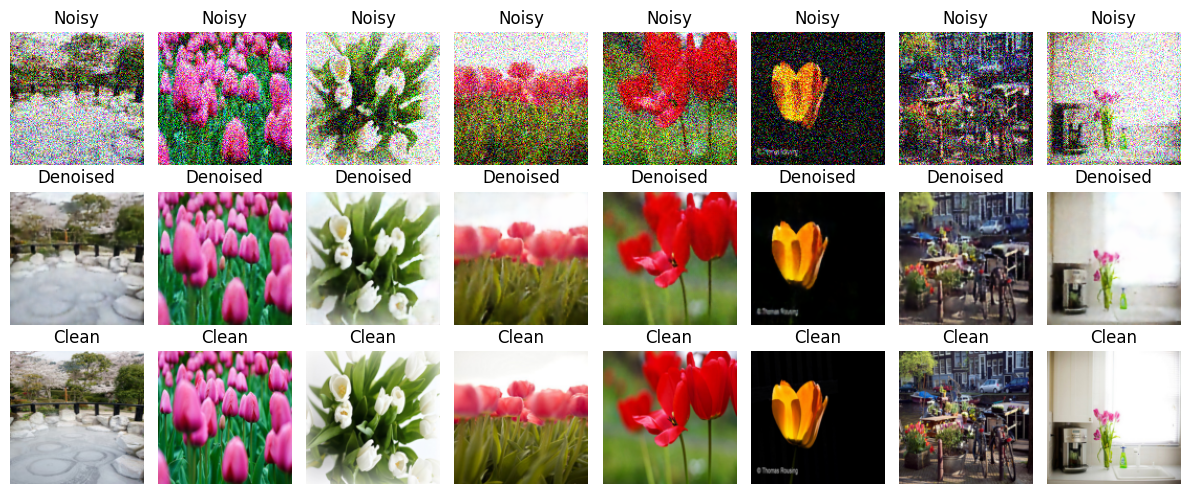

In [33]:
#VISUALIZING OUR UNET MODEL (ACCURACY 97%)

import matplotlib.pyplot as plt

# Re-instantiate the model and load weights (on CPU)
model = UNet(in_channels=3, out_channels=3)
model.load_state_dict(torch.load(r'C:\Users\ruchi\Documents\Python notebooks\unet_denoising_model_1.pth', map_location='cpu'))
model.eval()

# Pick a batch (e.g., first batch)
with torch.no_grad():
    noisy_sample = noisy_images[:8].cpu()  # ensure on CPU
    clean_sample = clean_images[:8].cpu()
    output = model(noisy_sample)

# Move tensors to numpy for plotting
noisy_np = noisy_sample.numpy()
clean_np = clean_sample.numpy()
output_np = output.numpy()

# Plot the results
n = noisy_np.shape[0]
plt.figure(figsize=(12, 5))
for i in range(n):
    # Noisy input
    plt.subplot(3, n, i+1)
    plt.imshow(np.transpose(noisy_np[i], (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')
    # Model output
    plt.subplot(3, n, n+i+1)
    plt.imshow(np.transpose(output_np[i], (1, 2, 0)))
    plt.title("Denoised")
    plt.axis('off')
    # Ground truth
    plt.subplot(3, n, 2*n+i+1)
    plt.imshow(np.transpose(clean_np[i], (1, 2, 0)))
    plt.title("Clean")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [45]:
output_folder = r'C:\Users\ruchi\Documents\Denoised_Outputs'
os.makedirs(output_folder, exist_ok=True)

for i, img_tensor in enumerate(test_denoised):
    img_np = img_tensor.permute(1, 2, 0).numpy()

    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    img_pil.save(os.path.join(output_folder, f'denoised_image_{i:04d}.png'))


In [34]:
#DENOISING OUR ENTIRE TEST SET, IN BATCHES TO AVOID RUNNING OUT OF GPU MEMORY
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


denoised_batches = []

with torch.no_grad():
    dataset = TensorDataset(test_noisy)
    batch_size = 32
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    for batch_idx, (images_batch,) in enumerate(dataloader):
        images_batch = images_batch.to(device)
        denoised_batch = model(images_batch)

        print(f"Processing batch {batch_idx+1}, shape: {images_batch.shape}")
        denoised_batches.append(denoised_batch.cpu())




test_denoised = torch.cat(denoised_batches, dim=0)

Processing batch 1, shape: torch.Size([32, 3, 128, 128])
Processing batch 2, shape: torch.Size([32, 3, 128, 128])
Processing batch 3, shape: torch.Size([32, 3, 128, 128])
Processing batch 4, shape: torch.Size([32, 3, 128, 128])
Processing batch 5, shape: torch.Size([32, 3, 128, 128])
Processing batch 6, shape: torch.Size([32, 3, 128, 128])
Processing batch 7, shape: torch.Size([32, 3, 128, 128])
Processing batch 8, shape: torch.Size([32, 3, 128, 128])
Processing batch 9, shape: torch.Size([32, 3, 128, 128])
Processing batch 10, shape: torch.Size([32, 3, 128, 128])
Processing batch 11, shape: torch.Size([32, 3, 128, 128])
Processing batch 12, shape: torch.Size([32, 3, 128, 128])
Processing batch 13, shape: torch.Size([32, 3, 128, 128])
Processing batch 14, shape: torch.Size([32, 3, 128, 128])
Processing batch 15, shape: torch.Size([32, 3, 128, 128])
Processing batch 16, shape: torch.Size([32, 3, 128, 128])
Processing batch 17, shape: torch.Size([32, 3, 128, 128])
Processing batch 18, sh

In [35]:
test_denoised.shape

torch.Size([772, 3, 128, 128])

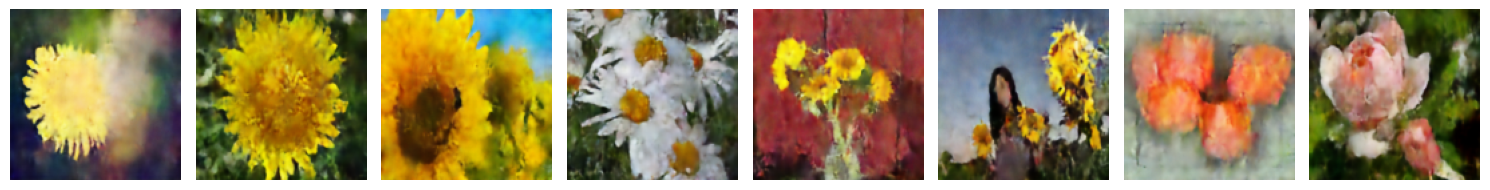

In [36]:
#VISUALIZE THE TEST DENOISED TO CHECK IF ITS IN THE RIGHT ORDER
import matplotlib.pyplot as plt
import numpy as np

# Get the first 8 images from the test_denoised tensor
num_images_to_show = 8
images_to_show = test_denoised[:num_images_to_show].cpu().permute(0, 2, 3, 1).numpy()

# Plot the images
plt.figure(figsize=(15, 5))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images_to_show[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [37]:
denoised_noisy_train_tensors = []
model.to(device)
model.eval()
batch_size = 32



with torch.no_grad():
    for noisy_tensor in noisy_tensors_list:
        noisy_dataset = TensorDataset(noisy_tensor)
        noisy_dataloader = DataLoader(noisy_dataset, batch_size=batch_size, shuffle=False)

        denoised_batches_for_tensor = []
        for noisy_batch, in noisy_dataloader:
            noisy_batch = noisy_batch.to(device)

            denoised_output_batch = model(noisy_batch)
            denoised_batches_for_tensor.append(denoised_output_batch.cpu())

        #CONCATENATE THE LIST AND ADD THE DENOSIED TENSOR
        denoised_tensor = torch.cat(denoised_batches_for_tensor, dim=0)
        denoised_noisy_train_tensors.append(denoised_tensor)







print(len(denoised_noisy_train_tensors))

5


In [38]:
for i, denoised_tensor in enumerate(denoised_noisy_train_tensors[:8]):
    print(f"Denoised tensor {i+1} shape: {denoised_tensor.shape}")


Denoised tensor 1 shape: torch.Size([391, 3, 128, 128])
Denoised tensor 2 shape: torch.Size([310, 3, 128, 128])
Denoised tensor 3 shape: torch.Size([439, 3, 128, 128])
Denoised tensor 4 shape: torch.Size([313, 3, 128, 128])
Denoised tensor 5 shape: torch.Size([342, 3, 128, 128])


In [39]:
merged_denoised_train_tensors = torch.cat(denoised_noisy_train_tensors, dim=0) #MERGE THE DENOISED TENSOR LIST INTO ONE TENSOR


num_tulips = len(denoised_noisy_train_tensors[0])
num_daisy = len(denoised_noisy_train_tensors[1])
num_dandelion = len(denoised_noisy_train_tensors[2])
num_roses = len(denoised_noisy_train_tensors[3])
num_sunflowers = len(denoised_noisy_train_tensors[4])

tulips_labels_denoised = torch.full((num_tulips,), 4, dtype=torch.long)     #GIVING THE PROPER LABELS ACCORDING TO THE REQUIREMENT
daisy_labels_denoised = torch.full((num_daisy,), 0, dtype=torch.long)
dandelion_labels_denoised = torch.full((num_dandelion,), 1, dtype=torch.long)
roses_labels_denoised = torch.full((num_roses,), 2, dtype=torch.long)
sunflowers_labels_denoised = torch.full((num_sunflowers,), 3, dtype=torch.long)

merged_labels = torch.cat([            #MERGING THE LABELS AND THE TENSORS INTO ANOTHER DIMENSION
    tulips_labels_denoised,
    daisy_labels_denoised,
    dandelion_labels_denoised,
    roses_labels_denoised,
    sunflowers_labels_denoised
], dim=0)


print(merged_denoised_train_tensors.shape)
print(merged_labels.shape)

torch.Size([1795, 3, 128, 128])
torch.Size([1795])


In [40]:
#MORE COMPLEX AUGMENTATION FROM IEEE XPLORE
complex_augment_transforms = v2.Compose([
    v2.RandomRotation(degrees=40),
    v2.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    v2.RandomHorizontalFlip(p=0.5),
])



In [41]:
doubled_train_images = torch.cat([clean_images, merged_denoised_train_tensors], dim=0)
doubled_train_labels = torch.cat([merged_labels, merged_labels], dim=0)#DOUBLES THE TRAINING SET


In [23]:
additional_augmented_copies = torch.stack([complex_augment_transforms(img) for img in doubled_train_images])# APLYING THE COMPLEX AUGMENTATION
tripled_train_images = torch.cat([doubled_train_images, additional_augmented_copies], dim=0)#TRIPLING OUR ORIGINAL DATASET
tripled_train_labels = torch.cat([doubled_train_labels, doubled_train_labels], dim=0) #CONCATENATE TO MAKE OUR LABELS MATCH




#NEW TENSOR DATAEST
tripled_augmented_dataset = TensorDataset(tripled_train_images, tripled_train_labels)


tripled_augmented_train_dataloader = DataLoader(tripled_augmented_dataset, batch_size=batch_size, shuffle=True)

print(len(tripled_augmented_dataset))


7180


**Reasoning**:
Initialize the CNN classifier model, define the loss function and optimizer, and move the model to the appropriate device as per the instructions.



In [42]:
# Initialize model and move to device
# Use the same CNNClassifier architecture as before
classifier_model_augmented = CNNClassifier(num_classes=5).to(device)

# Define loss function and optimizer (same as before)
classifier_criterion_augmented = nn.CrossEntropyLoss()
classifier_optimizer_augmented = torch.optim.Adam(classifier_model_augmented.parameters(), lr=0.001)

print("CNN classifier model, loss function, and optimizer initialized for augmented data training.")

NameError: name 'CNNClassifier' is not defined

In [43]:
num_epochs_C = 200
for epoch in range(num_epochs_C):
    classifier_model_augmented.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0


    for inputs, labels in tripled_augmented_train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)


        classifier_optimizer_augmented.zero_grad()


        outputs = classifier_model_augmented(inputs)


        loss = classifier_criterion_augmented(outputs, labels)


        loss.backward()


        classifier_optimizer_augmented.step()


        running_loss += loss.item() * inputs.size(0)


        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()


    epoch_loss = running_loss / len(tripled_augmented_dataset)
    epoch_accuracy = 100 * correct_predictions / total_predictions

    print(f'Epoch [{epoch+1}/{num_epochs_C}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')


    if (epoch + 1) % 10 == 0:
         torch.save(classifier_model_augmented.state_dict(), f'/content/new_cnn_classifier_tripled_augmented_epoch_{epoch+1}.pth')

NameError: name 'num_epochs_doubled_data_classifier' is not defined

In [ ]:

classifier_model_augmented = CNNClassifier(num_classes=5).to(device)

# Define loss function and optimizer (same as before)
classifier_criterion_augmented = nn.CrossEntropyLoss()
classifier_optimizer_augmented = torch.optim.Adam(classifier_model_augmented.parameters(), lr=0.001)

print("CNN classifier model, loss function, and optimizer initialized for augmented data training.")

# Define the number of epochs for training the classifier on the augmented data.
num_epochs_doubled_data_classifier = 200 # Define the number of epochs for training on doubled data

# Start the training loop iterating over the defined number of epochs.
for epoch in range(num_epochs_doubled_data_classifier):
    # Set the classifier_model_augmented to training mode using .train().
    classifier_model_augmented.train()

    # Initialize variables to track running loss and correct predictions for the epoch.
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate through the tripled_augmented_train_dataloader to get batches of augmented images and their corresponding labels.
    for inputs, labels in tripled_augmented_train_dataloader:
        # Move the image and label batches to the appropriate device (device).
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients of the classifier_optimizer_augmented.
        classifier_optimizer_augmented.zero_grad()

        # Perform a forward pass by passing the augmented image batch through classifier_model_augmented.
        outputs = classifier_model_augmented(inputs)

        # Calculate the loss using classifier_criterion_augmented and the model's outputs and the true labels.
        loss = classifier_criterion_augmented(outputs, labels)

        # Perform a backward pass by calling .backward() on the calculated loss.
        loss.backward()

        # Update the model's weights by calling .step() on classifier_optimizer_augmented.
        classifier_optimizer_augmented.step()

        # Update the running loss and the count of correct predictions for the epoch.
        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate the average training loss and accuracy for the epoch after iterating through all batches.
    epoch_loss = running_loss / len(tripled_augmented_dataset)
    epoch_accuracy = 100 * correct_predictions / total_predictions

    # Validation phase
    # Set the classifier_model_augmented to evaluation mode using .eval().
    classifier_model_augmented.eval()

    # Initialize variables to track validation loss and correct predictions for the epoch.
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    # Use a torch.no_grad() block to disable gradient calculation during validation.
    with torch.no_grad():
        # Iterate through the val_classifier_dataloader to get batches of validation images and their corresponding labels.
        for inputs_val, labels_val in val_classifier_dataloader:
            # Move the validation image and label batches to the appropriate device (device).
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            # Perform a forward pass by passing the validation image batch through classifier_model_augmented.
            outputs_val = classifier_model_augmented(inputs_val)

            # 7. Calculate the validation loss using classifier_criterion_augmented.
            loss_val = classifier_criterion_augmented(outputs_val, labels_val)

            # Update the running validation loss and the count of correct predictions for the epoch.
            val_running_loss += loss_val.item() * inputs_val.size(0)

            # Calculate accuracy
            _, predicted_val = torch.max(outputs_val.data, 1)
            val_total_predictions += labels_val.size(0)
            val_correct_predictions += (predicted_val == labels_val).sum().item()

    # Calculate the average validation loss and accuracy for the epoch after iterating through all validation batches.
    val_epoch_loss = val_running_loss / len(val_subset_classifier)
    val_epoch_accuracy = 100 * val_correct_predictions / val_total_predictions


    # Print the epoch number, training loss, training accuracy, validation loss, and validation accuracy.
    print(f'Epoch [{epoch+1}/{num_epochs_doubled_data_classifier}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%')

    # Save model checkpoint periodically (optional, but good practice)
    if (epoch + 1) % 10 == 0:
         torch.save(classifier_model_augmented.state_dict(), f'/content/new_cnn_classifier_tripled_augmented_epoch_{epoch+1}.pth')

CNN classifier model, loss function, and optimizer initialized for augmented data training.
Epoch [1/200], Train Loss: 1.5732, Train Accuracy: 47.76%, Val Loss: 0.9862, Val Accuracy: 55.99%
Epoch [2/200], Train Loss: 1.0616, Train Accuracy: 57.13%, Val Loss: 0.8427, Val Accuracy: 66.30%
Epoch [3/200], Train Loss: 0.9926, Train Accuracy: 60.36%, Val Loss: 0.9912, Val Accuracy: 57.94%
Epoch [4/200], Train Loss: 0.9501, Train Accuracy: 62.52%, Val Loss: 0.8696, Val Accuracy: 66.57%
Epoch [5/200], Train Loss: 0.9237, Train Accuracy: 64.03%, Val Loss: 0.7894, Val Accuracy: 66.30%
Epoch [6/200], Train Loss: 0.8782, Train Accuracy: 65.65%, Val Loss: 1.0215, Val Accuracy: 57.94%
Epoch [7/200], Train Loss: 0.8579, Train Accuracy: 67.03%, Val Loss: 0.6418, Val Accuracy: 77.16%
Epoch [8/200], Train Loss: 0.8124, Train Accuracy: 68.76%, Val Loss: 0.6987, Val Accuracy: 72.42%
Epoch [9/200], Train Loss: 0.7901, Train Accuracy: 69.79%, Val Loss: 0.7720, Val Accuracy: 70.75%
Epoch [10/200], Train Loss

In [ ]:
display(predicted_labels_augmented_model_tensor)

tensor([1, 1, 3, 0, 4, 3, 2, 2, 2, 3, 1, 3, 1, 4, 0, 3, 0, 1, 0, 1, 3, 4, 4, 1,
        4, 0, 4, 1, 0, 2, 1, 1, 3, 4, 0, 1, 2, 1, 3, 4, 1, 4, 3, 1, 3, 2, 3, 0,
        0, 1, 4, 4, 3, 0, 3, 1, 0, 4, 2, 4, 4, 3, 4, 3, 1, 2, 2, 4, 4, 3, 0, 4,
        4, 2, 1, 0, 1, 3, 1, 4, 3, 4, 3, 3, 4, 0, 1, 2, 3, 3, 1, 1, 4, 4, 1, 1,
        2, 1, 4, 1, 4, 2, 1, 3, 2, 1, 0, 3, 3, 2, 1, 4, 1, 4, 1, 2, 1, 1, 3, 4,
        4, 3, 4, 0, 2, 3, 1, 3, 0, 4, 1, 1, 0, 4, 2, 3, 1, 3, 0, 1, 3, 2, 4, 2,
        2, 2, 1, 4, 3, 1, 0, 1, 3, 1, 1, 1, 3, 4, 3, 3, 4, 1, 3, 4, 1, 4, 0, 1,
        4, 2, 1, 0, 2, 2, 3, 1, 2, 1, 4, 3, 1, 4, 2, 0, 3, 2, 4, 4, 2, 4, 0, 1,
        1, 2, 2, 3, 2, 3, 0, 4, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 0, 3, 1,
        2, 1, 2, 3, 2, 3, 0, 3, 1, 0, 3, 0, 4, 4, 2, 0, 3, 1, 3, 1, 1, 0, 3, 3,
        4, 1, 1, 3, 0, 2, 4, 2, 0, 1, 3, 3, 1, 0, 4, 0, 1, 0, 1, 4, 2, 1, 0, 1,
        2, 1, 0, 1, 4, 4, 0, 3, 3, 4, 2, 4, 3, 3, 4, 0, 2, 2, 0, 4, 1, 1, 3, 1,
        3, 4, 0, 0, 3, 2, 0, 4, 0, 2, 3,

In [ ]:
correct_predicted_labels_augmented_model_tensor = predicted_labels_augmented_model_tensor+1
correct_predicted_labels_augmented_model_tensor

tensor([2, 2, 4, 1, 5, 4, 3, 3, 3, 4, 2, 4, 2, 5, 1, 4, 1, 2, 1, 2, 4, 5, 5, 2,
        5, 1, 5, 2, 1, 3, 2, 2, 4, 5, 1, 2, 3, 2, 4, 5, 2, 5, 4, 2, 4, 3, 4, 1,
        1, 2, 5, 5, 4, 1, 4, 2, 1, 5, 3, 5, 5, 4, 5, 4, 2, 3, 3, 5, 5, 4, 1, 5,
        5, 3, 2, 1, 2, 4, 2, 5, 4, 5, 4, 4, 5, 1, 2, 3, 4, 4, 2, 2, 5, 5, 2, 2,
        3, 2, 5, 2, 5, 3, 2, 4, 3, 2, 1, 4, 4, 3, 2, 5, 2, 5, 2, 3, 2, 2, 4, 5,
        5, 4, 5, 1, 3, 4, 2, 4, 1, 5, 2, 2, 1, 5, 3, 4, 2, 4, 1, 2, 4, 3, 5, 3,
        3, 3, 2, 5, 4, 2, 1, 2, 4, 2, 2, 2, 4, 5, 4, 4, 5, 2, 4, 5, 2, 5, 1, 2,
        5, 3, 2, 1, 3, 3, 4, 2, 3, 2, 5, 4, 2, 5, 3, 1, 4, 3, 5, 5, 3, 5, 1, 2,
        2, 3, 3, 4, 3, 4, 1, 5, 1, 3, 1, 2, 2, 2, 2, 1, 1, 2, 3, 2, 2, 1, 4, 2,
        3, 2, 3, 4, 3, 4, 1, 4, 2, 1, 4, 1, 5, 5, 3, 1, 4, 2, 4, 2, 2, 1, 4, 4,
        5, 2, 2, 4, 1, 3, 5, 3, 1, 2, 4, 4, 2, 1, 5, 1, 2, 1, 2, 5, 3, 2, 1, 2,
        3, 2, 1, 2, 5, 5, 1, 4, 4, 5, 3, 5, 4, 4, 5, 1, 3, 3, 1, 5, 2, 2, 4, 2,
        4, 5, 1, 1, 4, 3, 1, 5, 1, 3, 4,

In [ ]:
predicted_labels_augmented_model = []
with torch.no_grad():
    for images_batch, in test_dataloader_denoised:
        images_batch = images_batch.to(device)
        outputs = classifier_model_augmented_test(images_batch)
        _, predicted = torch.max(outputs.data, 1)#FIND THE CLASS WHICH HAS THE HIGEHST SCORE

        predicted_labels_augmented_model.extend(predicted.cpu().numpy().tolist())


predicted_labels_augmented_model_tensor = torch.tensor(predicted_labels_augmented_model, dtype=torch.long)



Total number of predictions using augmented model: 772


In [ ]:
# 1. Load the trained classifier model (assuming the last saved epoch is the best, or load a specific one if known)
# You would ideally load the model with the best validation accuracy from the checkpoints
# For simplicity, we'll load the last saved model state from the tripled augmented training
best_model_path_augmented = '/content/new_cnn_classifier_tripled_augmented_epoch_200.pth'  # Assuming epoch 200 was the last or best
classifier_model_augmented_test = CNNClassifier(num_classes=5) # Re-instantiate the model architecture

# Load the saved state dictionary
classifier_model_augmented_test.load_state_dict(torch.load(best_model_path_augmented, map_location=device)) # Load to the appropriate device

# 2. Move the model to the appropriate device (already done during loading)
classifier_model_augmented_test.to(device)

# 3. Set the model to evaluation mode
classifier_model_augmented_test.eval()

# 4. Create a TensorDataset from test_denoised
# test_denoised is already a tensor from the denoising step
test_dataset_denoised = TensorDataset(test_denoised)

# 5. Create a DataLoader for the test dataset
batch_size = 32
test_dataloader_denoised = DataLoader(test_dataset_denoised, batch_size=batch_size, shuffle=False)

print("Augmented data trained classifier model loaded and set to evaluation mode.")
print(f"Denoised test dataset size: {len(test_dataset_denoised)}")

Augmented data trained classifier model loaded and set to evaluation mode.
Denoised test dataset size: 772


In [47]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/12.9 MB 16.6 MB/s eta 0:00:01
   ---------- ----------------------------- 3.4/12.9 MB 10.1 MB/s eta 0:00:01
   ------------------------ --------------- 7.9/12.9 MB 14.7 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 17.9 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 15.0 MB/s  0:00:00

   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [

In [48]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Load the clean test images
# Assuming the clean test images are in a similar folder structure as the noisy ones
# You might need to adjust this path based on your dataset structure
clean_test = folder_to_tensor(r'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\test\clean')


# Convert tensors to numpy arrays and adjust data range if necessary (e.g., 0-255)
# Assuming the tensors are in the range [0, 1]
noisy_np = test_noisy.permute(0, 2, 3, 1).numpy()
denoised_np = test_denoised.permute(0, 2, 3, 1).numpy()
clean_np = clean_test.permute(0, 2, 3, 1).numpy()

# Ensure data types are suitable for skimage metrics (e.g., float64)
noisy_np = noisy_np.astype(np.float64)
denoised_np = denoised_np.astype(np.float64)
clean_np = clean_np.astype(np.float64)


# Calculate PSNR and SSIM
psnr_before = []
ssim_before = []
psnr_after = []
ssim_after = []

for i in range(clean_np.shape[0]):
    # PSNR and SSIM before denoising (noisy vs clean)
    psnr_b = peak_signal_noise_ratio(clean_np[i], noisy_np[i], data_range=1.0) # Assuming data range is 0-1 after ToTensor
    ssim_b = structural_similarity(clean_np[i], noisy_np[i], data_range=1.0, channel_axis=-1) # Assuming data range is 0-1 and channel is last dimension


    # PSNR and SSIM after denoising (denoised vs clean)
    psnr_a = peak_signal_noise_ratio(clean_np[i], denoised_np[i], data_range=1.0) # Assuming data range is 0-1 after ToTensor
    ssim_a = structural_similarity(clean_np[i], denoised_np[i], data_range=1.0, channel_axis=-1) # Assuming data range is 0-1 and channel is last dimension

    psnr_before.append(psnr_b)
    ssim_before.append(ssim_b)
    psnr_after.append(psnr_a)
    ssim_after.append(ssim_a)

# Calculate average PSNR and SSIM
avg_psnr_before = np.mean(psnr_before)
avg_ssim_before = np.mean(ssim_before)
avg_psnr_after = np.mean(psnr_after)
avg_ssim_after = np.mean(ssim_after)

print(f"Average PSNR before denoising: {avg_psnr_before:.4f}")
print(f"Average SSIM before denoising: {avg_ssim_before:.4f}")
print(f"Average PSNR after denoising: {avg_psnr_after:.4f}")
print(f"Average SSIM after denoising: {avg_ssim_after:.4f}")

No PNG images found in 'C:\Users\ruchi\Documents\180-dc-ml-sig-recruitment\REC_DATASET\test\clean'.


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 4